#### code to plot radiosonde data binned as a function of sst
#### author: Claudia Acquistapace
#### date: 01/12/2021
#### goal: read the post-processed file containing the radiosonde data binned and re-organized as a function of SST and plot them accordingly



In [1]:

# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

def f_generate_list_binned_var(var_list, var_name_string):
    output_list = []
    n_elements_list = len(var_list)
    for i,el in enumerate(var_list):
        output_list.append(el[var_name_string].values)
    return(output_list)

In [4]:
# reading radiosondes
#path_RS_postprocessed_data = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
path_plot = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
path_RS_postprocessed_data = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'

# read rs data
RS_atalante_Data_new = xr.open_dataset(path_RS_postprocessed_data+'radiosondes_atalante_merian_binned_sst.nc')

# reading data produced after reviewer's comment
q_data_review = xr.open_dataset(('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/q_data_comment_reviewer.nc'))
q_raw = xr.open_dataset(('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/q_file_review.nc'))


# reading mixing ratio averaged profiles over sst from DL
dataset_mr = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_all_MR.nc')
dataset_averaged_on_sst =xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_MR_coarser_sst.nc')


In [5]:
RS_atalante_Data_new

<xarray.Dataset>
Dimensions:     (height: 3100, sst: 53)
Coordinates:
  * sst         (sst) float64 26.34 26.36 26.41 26.45 ... 27.47 27.5 27.61 27.67
  * height      (height) int16 0 10 20 30 40 ... 30950 30960 30970 30980 30990
Data variables:
    lts         (sst) float64 ...
    eis         (sst) float64 ...
    cf          (sst) float64 ...
    cbh         (sst) float64 ...
    lcl         (sst) float64 ...
    pblh        (sst) float64 ...
    longitude   (sst, height) float32 ...
    latitude    (sst, height) float32 ...
    pressure    (sst, height) float32 ...
    wvmr        (sst, height) float32 ...
    wind_dir    (sst, height) float32 ...
    wind_speed  (sst, height) float32 ...
    rh          (sst, height) float32 ...
    ta          (sst, height) float32 ...
    theta_v     (sst, height) float64 ...
    theta       (sst, height) float32 ...

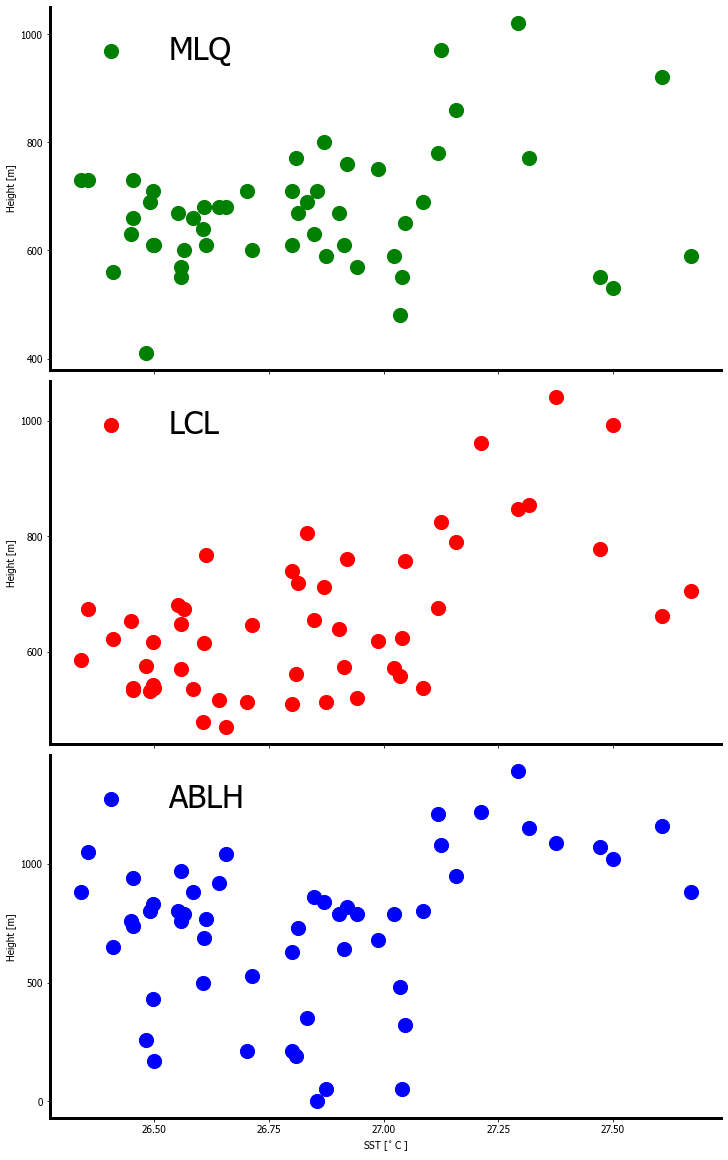

In [6]:
RS_atalante_Data_new
# create scatter plot of MLQ, LCL, ABLH, vs SST
fig, ax1 = plt.subplots(3,1, figsize=(10,16), sharex=True, constrained_layout=True)

dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
ax1[0].scatter(q_raw.sst.values, q_raw.MLQ.values, label='MLQ', color='green', s=200)
ax1[1].scatter(RS_atalante_Data_new.sst.values, RS_atalante_Data_new.lcl.values, label='LCL', color='red', s=200)
ax1[2].scatter(RS_atalante_Data_new.sst.values, RS_atalante_Data_new.pblh.values, label='ABLH', color='blue', s=200)
ax1[2].set_xlabel('SST [$^{\circ}$ C ]')

for axs in ax1:
    axs.legend(frameon=False)

    axs.set_ylabel('Height [m]')
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    
fig.savefig(path_plot+'scatter_plot_RS_data_R1.png')


In [7]:
# building binned array of sst
sst_tsg_RS = RS_atalante_Data_new.sst.values
bin_size = 0.25
binned_sst = np.round(np.arange(np.nanmin(sst_tsg_RS),np.nanmax(sst_tsg_RS), bin_size),1)
print(binned_sst)

#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(binned_sst)))


# calculating mean and std properties for each bin of sst
list_binned_datasets = []
list_test = []
for ind_sst in range(len(binned_sst)):
    
    # slicing the bin of sst selected
    #sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
    # slicing the bin of sst selected
    if ind_sst < len(binned_sst)-2:
        sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
        print(binned_sst[ind_sst])
        print(binned_sst[ind_sst+1])
    elif ind_sst == len(binned_sst)-2:
        print('last bin')
        print(binned_sst[ind_sst])
        print(np.nanmax(RS_atalante_Data_new.sst.values))
        sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], np.nanmax(RS_atalante_Data_new.sst.values)))
    else:
        break
        
    # saving the slice in a list
    list_binned_datasets.append(sliced_data_SST)
    
    # calculating quantiles of the slice
    list_test.append(sliced_data_SST.quantile([0, 0.25, 0.5, 0.75, 1], dim="sst", skipna=True))
    

# calculate label marks for bins
sst_bin_label = []
for ind in range(len(binned_sst)-1):
    if ind == 0:
        sst_bin_label.append(round((np.nanmin(RS_atalante_Data_new.sst.values)+binned_sst[ind+1])/2,2))
    elif ind < len(binned_sst)-2:
        sst_bin_label.append(round((binned_sst[ind]+binned_sst[ind+1])/2,2))
    else:
        sst_bin_label.append(round((binned_sst[ind]+np.nanmax(RS_atalante_Data_new.sst.values))/2,2))


[26.3 26.6 26.8 27.1 27.3 27.6]
26.3
26.6


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


26.6
26.8
26.8
27.1
27.1
27.3
last bin
27.3
27.6695


In [8]:
print(len(list_binned_datasets))
print(len(sst_bin_label))

#generate data arrays for boxplots of scalar quantities
lts_binned = f_generate_list_binned_var(list_binned_datasets, 'lts')
eis_binned = f_generate_list_binned_var(list_binned_datasets, 'eis')
lcl_binned = f_generate_list_binned_var(list_binned_datasets, 'lcl')
pblh_binned = f_generate_list_binned_var(list_binned_datasets, 'pblh')
cbh_binned = f_generate_list_binned_var(list_binned_datasets, 'cbh')
cf_binned = f_generate_list_binned_var(list_binned_datasets, 'cf')



5
5


In [9]:


# removing nans from the cloud base height data
cbh_binned_nonans = []
for ind,el in enumerate(cbh_binned):
    cbh_binned_test = el
    cbh_binned_nonans.append(cbh_binned_test[~np.isnan(cbh_binned_test)])
sst_bin_label
   


# calculate mean profile and std of profiled variables
list_std_binned_datasets = []
list_mean_binned_datasets = []

for ind,el in enumerate(list_binned_datasets):
    # calculating mean and standard deviation
    list_mean_binned_datasets.append(el.mean(dim='sst', skipna=True))
    list_std_binned_datasets.append(el.std(dim='sst', skipna=True))
list_mean_binned_datasets[0]




<xarray.Dataset>
Dimensions:     (height: 3100)
Coordinates:
  * height      (height) int16 0 10 20 30 40 ... 30950 30960 30970 30980 30990
Data variables:
    lts         float64 13.6
    eis         float64 1.121
    cf          float64 0.1239
    cbh         float64 806.4
    lcl         float64 595.6
    pblh        float64 731.9
    longitude   (height) float32 -54.114693 -54.188435 -54.18937 ... nan nan nan
    latitude    (height) float32 6.565909 6.6390443 6.646218 ... nan nan nan
    pressure    (height) float32 nan nan nan nan 101096.94 ... nan nan nan nan
    wvmr        (height) float32 nan nan nan nan 0.016488744 ... nan nan nan nan
    wind_dir    (height) float32 nan nan nan nan 47.92276 ... nan nan nan nan
    wind_speed  (height) float32 nan nan nan nan 7.33681 ... nan nan nan nan nan
    rh          (height) float32 nan nan nan nan 75.765495 ... nan nan nan nan
    ta          (height) float32 nan nan nan nan 299.4212 ... nan nan nan nan
    theta_v     (height) float64 nan nan nan nan 301.5 ... nan nan nan nan nan
    theta       (height) float32 nan nan nan nan 298.4896 ... nan nan nan nan

In [79]:
# calculating MLQ mean and STD over the bin size for Doppler lidar data
dataset_mr

MLQ_arr_all = np.zeros(len(dataset_mr.time.values))
MLQ_arr_all.fill(np.nan)
SST_arr_all  = np.zeros(len(dataset_mr.time.values))
SST_arr_all.fill(np.nan)
height = dataset_mr.height.values
 # reading the q profile
q = dataset_mr.product_no_noise.values

print(np.shape(q))

# calculating ML for each profile of the dataset_mr
for ind_time in range(len(dataset_mr.time.values)):
        
    ind_h = 0
    
    if (len(np.where(np.isnan(q[ind_time,:]))[0]) == len(q[ind_time,:])):
        #print('sono qui')
        MLQ_arr_all[ind_time] = np.nan
    else:
        # find minimum height where there's a q obs in RS profiles
        while(np.isnan(q[ind_time,ind_h]) * (ind_h < 3100)):
            ind_h = ind_h+1
        q0 = q[ind_time,ind_h]

        # find height at which q(z) < q[0]-1
        qo_prof = np.zeros(len(q[ind_time,:]))
        qo_prof.fill(q0-1.)
        diff = abs(q[ind_time,:] - qo_prof)

        #print((np.where(el.q.values < q0-1.)[0][0]))
        MLQ_arr_all[ind_time] = height[np.nanargmin(diff)]
    SST_arr_all[ind_time] = dataset_mr.SST.values[ind_time]
    

# sorting SST values and corresponding MLQ values
ind_SST_sorted = np.argsort(SST_arr_all)
SST_sorted = SST_arr_all[ind_SST_sorted]
MLO_sorted = MLQ_arr_all[ind_SST_sorted]


MLQ = []

for ind_sst in range(len(binned_sst)-1):
    
    # slicing the bin of sst selected
    #sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
    # slicing the bin of sst selected
    if ind_sst < len(binned_sst)-1:
        sst_inf = binned_sst[ind_sst]
        sst_sup = binned_sst[ind_sst+1]
        ind_sel = np.where((SST_sorted > sst_inf) * (SST_sorted <= sst_sup))[0]

    elif ind_sst == len(binned_sst)-1:
        sst_inf = binned_sst[ind_sst]
        ind_sel = np.where((SST_sorted > sst_inf))[0]    
    print(sst_inf, sst_sup)
    # calculating mean and std
    values = MLO_sorted[ind_sel]
    values = values[~np.isnan(values)]
    MLQ.append(values)



    
    

(16617, 57)
26.3 26.6
26.6 26.8
26.8 27.1
27.1 27.3
27.3 27.6


In [80]:
MLQ

[array([ 675., 1025.,  725., ...,  475.,  775.,  225.]),
 array([ 625.,  875.,  775., ..., 1675.,  975.,  875.]),
 array([ 675.,  675.,  825., ...,  725.,  675., 1225.]),
 array([ 575.,  475.,  925., ...,  725., 1375.,  225.]),
 array([975., 925., 925., ..., 875., 675., 875.])]

In [74]:
q_binned = q_data_review.MLQ.values

In [76]:
q_binned = q_data_review.MLQ.values
q_binned_list = []
n_sondes_per_bin = []
for ind in range(np.shape(q_binned)[0]):
    array = q_binned[ind,:]
    q_binned_list.append(array[~np.isnan(array)])
    print(len(array[~np.isnan(array)]))
    n_sondes_per_bin.append(len(array[~np.isnan(array)]))
print(q_binned_list)
n_sondes_per_bin = np.asarray(n_sondes_per_bin)

16
8
18
4
5
[array([730., 730., 560., 630., 730., 660., 410., 690., 610., 710., 610.,
       670., 550., 570., 600., 660.]), array([640., 680., 610., 680., 680., 710., 600., 710.]), array([610., 770., 670., 690., 630., 710., 800., 590., 670., 610., 760.,
       570., 750., 590., 480., 550., 650., 690.]), array([ 780.,  970.,  860., 1020.]), array([770., 550., 530., 920., 590.])]


In [10]:
# removing nans from the lcl_binned array
for ind in range(len(lcl_binned)):
    array = lcl_binned[ind]
    lcl_binned[ind] = array[~np.isnan(array)]
lcl_binned

[array([585.94, 673.91, 623.34, 653.97, 538.67, 534.9 , 576.1 , 532.33,
        617.7 , 542.55, 538.43, 681.18, 571.39, 648.37, 675.14, 536.08]),
 array([479.33, 615.31, 768.06, 516.69, 470.02, 512.98, 647.5 , 739.88]),
 array([510.04, 562.31, 718.81, 806.49, 655.55, 712.  , 513.15, 639.24,
        574.47, 761.6 , 520.48, 619.43, 572.  , 558.86, 624.51, 756.91,
        538.69]),
 array([676.62, 824.56, 791.07, 962.03, 847.74]),
 array([ 854.17, 1040.39,  778.7 ,  992.54,  662.32,  705.94])]

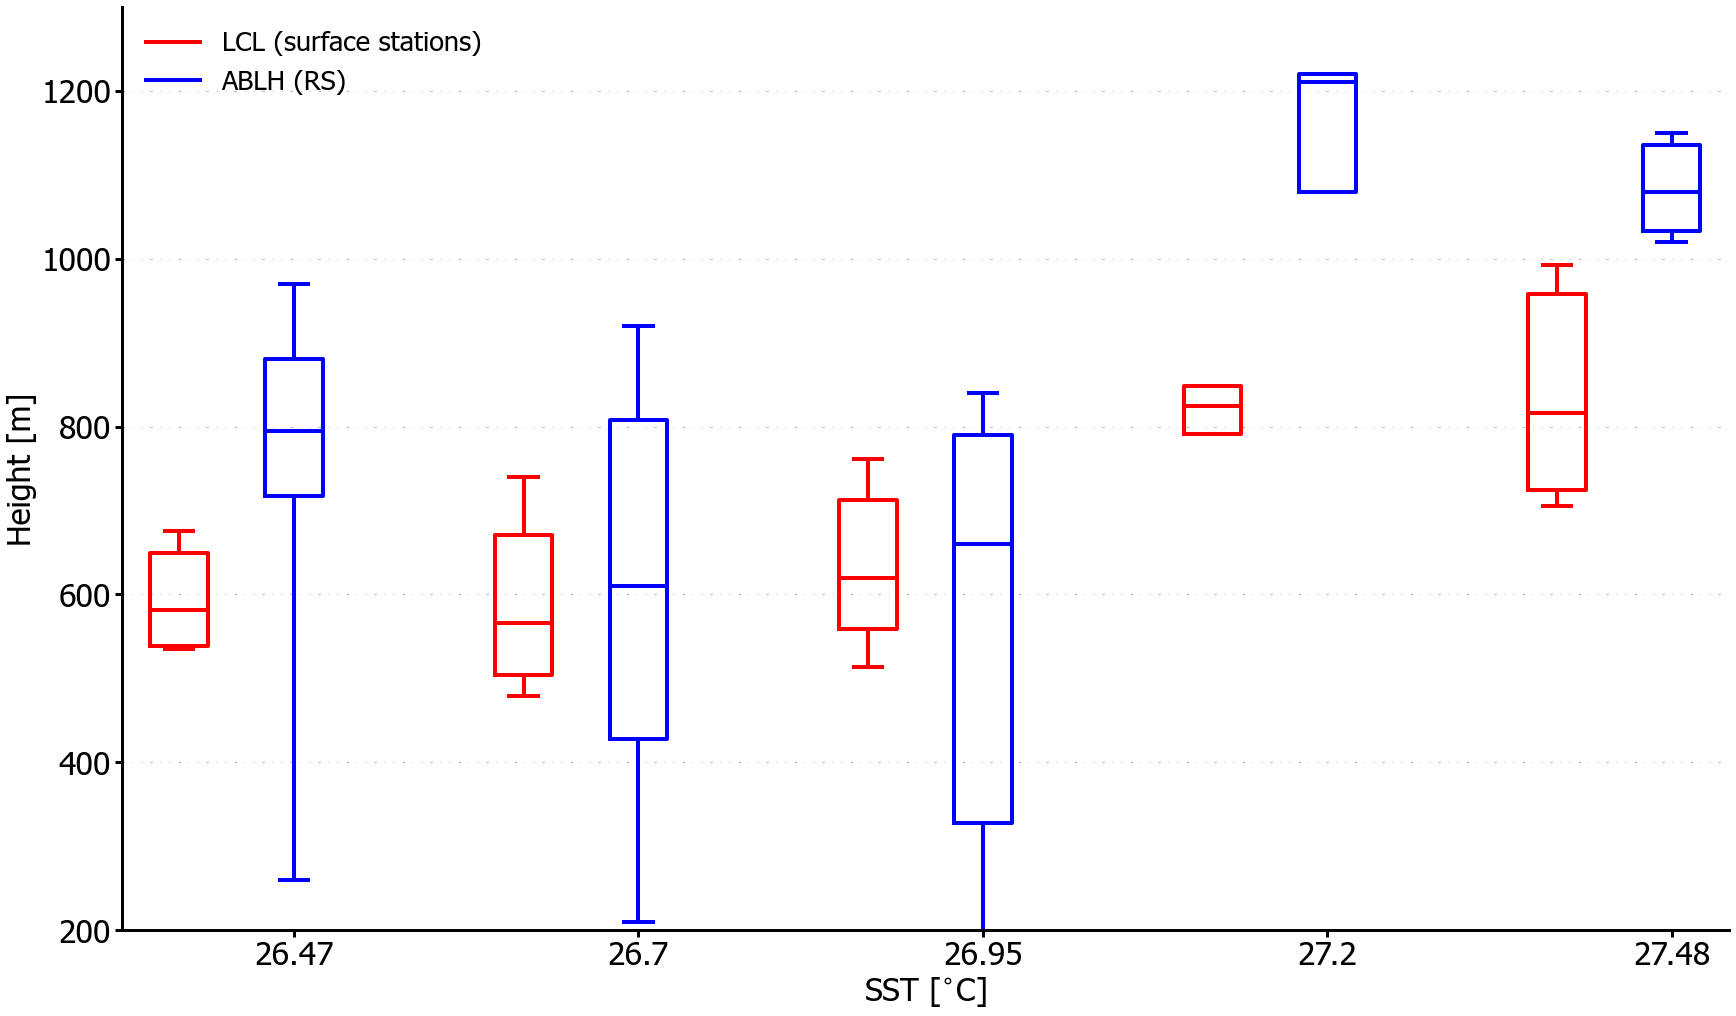

In [11]:
# plto boxplot of LCL and PBLH
fig, ax1 = plt.subplots(figsize=(24,14), sharex=True, constrained_layout=True)

dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
ax1.tick_params(which='minor', length=7, width=3)
ax1.tick_params(which='major', length=7, width=3)
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32) # sets dimension of ticks in the plots

fs = 32
#ax1.set_xlim(binned_sst[0]-1.5, binned_sst[-1]+0.1)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_linewidth(3)
ax1.spines["left"].set_linewidth(3)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax1.tick_params(which='minor', length=5, width=2)
ax1.tick_params(which='major', length=7, width=3)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax1.tick_params(axis='both', labelsize=dict_plot_settings['labelsizeaxes'])


axlim = [200, 1300] # axis limits for height in the y axis
labels_bp = sst_bin_label # labels for x axis of SST values
whis_lims = [1,99]

def make_boxplot_great_again(bp, col):	# change color and set linewidth to 1.5
    plt.setp(bp['boxes'], color=col, linewidth=4.)
    plt.setp(bp['whiskers'], color=col, linewidth=4.)
    plt.setp(bp['caps'], color=col, linewidth=4.)
    plt.setp(bp['medians'], color=col, linewidth=4.)


n_ins_plus = 3					# number of instruments in the box plot + 1
n_groups = len(sst_bin_label)		# e.g. number of months in data set
n_boxes = n_ins_plus*n_groups

# positions of boxes for each instrument:
pos_h = [n_ins_plus*k + 2 for k in range(n_groups)]
pos_q = [n_ins_plus*k + 3 for k in range(n_groups)]
pos_s = [n_ins_plus*k + 1 for k in range(n_groups)]

# BOXPLOT: whis = [5, 95] # to have 5th and 95th percentile as whiskers
# LCL
bp_plot_s = ax1.boxplot(lcl_binned, sym='', positions=pos_s, whis=whis_lims, widths=0.5)
# PBLH
bp_plot_h = ax1.boxplot(pblh_binned, sym='', positions=pos_h, whis=whis_lims, widths=0.5)
#bp_plot_q = ax1.boxplot(MLQ, sym='', positions=pos_q, whis=whis_lims, widths=0.5)

make_boxplot_great_again(bp_plot_s, col='red')
make_boxplot_great_again(bp_plot_h, col='blue')
#make_boxplot_great_again(bp_plot_q, col='darkseagreen')

# create dummy plots for legend:
ax1.plot([np.nan, np.nan], [np.nan, np.nan], linewidth=4.0, color='red', label='LCL (surface stations)')
ax1.plot([np.nan, np.nan], [np.nan, np.nan], linewidth=4.0, color='blue', label='ABLH (RS)')
#ax1.plot([np.nan, np.nan], [np.nan, np.nan], linewidth=4.0, color='darkseagreen', label='MLQ (DL)')

# # legend:
iwv_leg_handles, iwv_leg_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=iwv_leg_handles, labels=iwv_leg_labels, loc='upper left', fontsize=fs-5,
                framealpha=1.0, frameon=False)

# set axis limits and labels:
ax1.set_ylim(bottom=axlim[0], top=axlim[1])
ax1.set_ylabel("Height [m]", fontsize=fs)
ax1.set_xlabel("SST [$^{\circ}$C]", fontsize=fs)

#ax1[0].set_title("Integrated Water Vapour (IWV) during MOSAiC: October 2019 - October 2020", fontsize=fs)
#ax1.text(-0.05, 1.1, 'mean ABL height and LCL calculated from radiosondes averaged over SST bins',  fontweight='black', fontsize=fontSizeX, transform=ax1.transAxes)
ax1.set_xticks(pos_h)
ax1.set_xticklabels(labels_bp)
ax1.tick_params(axis='both', labelsize=fs)
ax1.grid(which='major', axis='y', color=(0.5,0.5,0.5), alpha=0.8, linestyle=(0, (3, 10, 1, 10, 1, 10)))

filled_marker_style = dict(marker='D', linestyle=':', s=350,
                           color='black')
#x2 = ax1.twinx()
#ax2.scatter(pos_h, n_sondes_per_bin, **filled_marker_style)
#ax2.spines["top"].set_visible(False)
#ax2.spines["right"].set_linewidth(3)
#ax2.spines["right"].set_visible(False)
#ax2.spines["left"].set_linewidth(3)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax1.tick_params(which='minor', length=5, width=2)
ax1.tick_params(which='major', length=7, width=3)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
#ax2.tick_params(axis='both', labelsize=dict_plot_settings['labelsizeaxes'])
#ax2.set_ylabel("sondes per bin [#]", fontsize=fs)

fig.savefig(path_plot+'wisker_lcl_pblh_R1.png')


In [80]:
np.sum(n_sondes_per_bin[-2:])

5

In [13]:
lcl_binned = lcl_binned[~np.isnan(lcl_binned)]
lcl_binned

<ipython-input-13-ba8a1cf2af8d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lcl_binned = lcl_binned[~np.isnan(lcl_binned)]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

NameError: name 'path_RS' is not defined

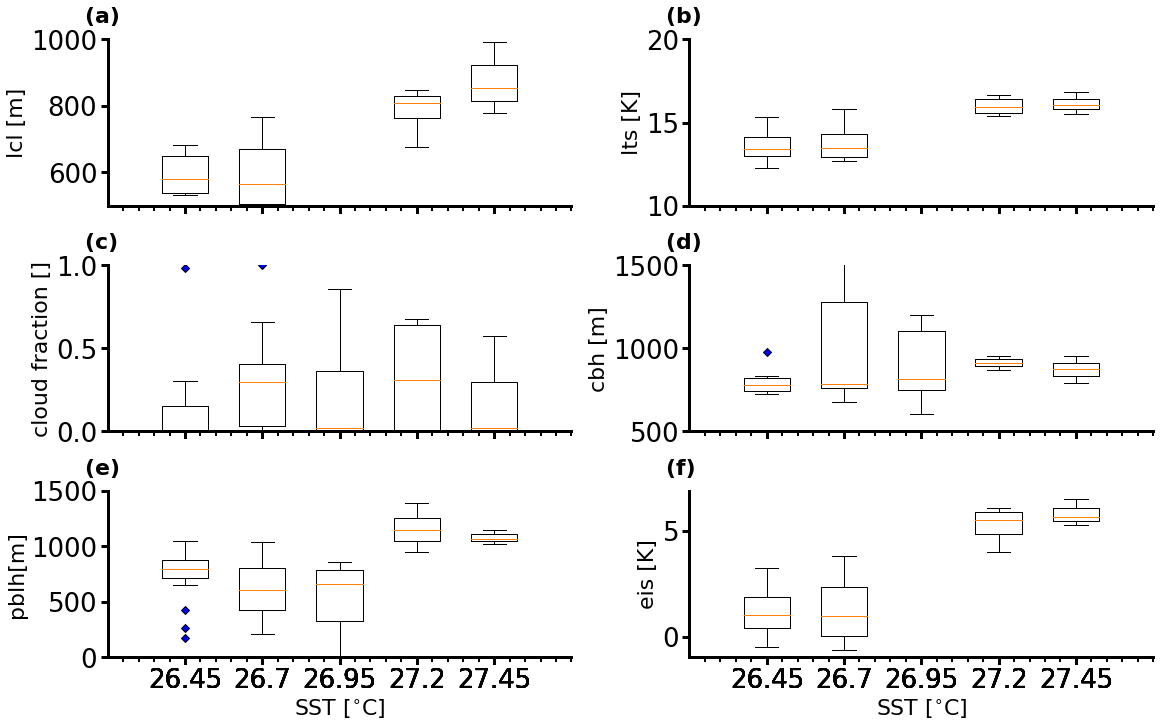

In [21]:

# composite figure variables binned in sst 
fig, axs = plt.subplots(3, 2, figsize=(16,10), sharex=True, constrained_layout=True)
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
val = 22
labelsizeaxes   = val
fontSizeTitle   = val
fontSizeX       = val
fontSizeY       = val
cbarAspect      = val
fontSizeCbar    = val
green_diamond = dict(markerfacecolor='b', marker='D')

axs[0,0].boxplot(lcl_binned, positions=sst_bin_label, notch=False, flierprops=green_diamond)
#axs[0].set_xlim(290.,325.)
axs[0,1].boxplot(lts_binned, positions=sst_bin_label, notch=False, flierprops=green_diamond)
axs[1,0].boxplot(cf_binned, positions=sst_bin_label, notch=False, flierprops=green_diamond)
axs[2,0].boxplot(pblh_binned, positions=sst_bin_label, notch=False, flierprops=green_diamond)
axs[2,1].boxplot(eis_binned, positions=sst_bin_label, notch=False, flierprops=green_diamond)
axs[1,1].boxplot(cbh_binned_nonans, positions=sst_bin_label, notch=False, flierprops=green_diamond)

axs[0,0].set_ylabel('lcl [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(500., 1000.)
axs[0,1].set_ylabel('lts [K]', fontsize=fontSizeX)
axs[0,1].set_ylim(10., 20.)
axs[1,0].set_ylabel('cloud fraction []', fontsize=fontSizeX)
axs[1,0].set_ylim(0., 1.)
axs[1,1].set_ylabel('cbh [m]', fontsize=fontSizeX)
axs[1,1].set_ylim(500., 1500.)
axs[2,0].set_ylabel('pblh[m]', fontsize=fontSizeX)
axs[2,0].set_ylim(0., 1500.)
axs[2,1].set_ylabel('eis [K]', fontsize=fontSizeX)
axs[2,0].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
axs[2,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=val, transform=ax.transAxes)
    ax.set_xlim(binned_sst[0]-0.1, binned_sst[-1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_RS+'scatter_binned_sst.png')

In [ ]:
# plot composite panel of profiles for different sst
fig, axs = plt.subplots(2, 4, figsize=(16,10), sharey=True, constrained_layout=True)
import matplotlib.font_manager as font_manager
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
labelsizeaxes   = 16
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 16
fontSizeCbar    = 16
labels =[]
for ind, el in enumerate(sst_bin_label):
    labels.append('SST = '+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)
for ind_dataset,DS in enumerate(list_mean_binned_datasets):
    
    #plot dataset mean and std of the radiosondes
    axs[0,0].plot(DS['theta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,0].legend(frameon=False, prop=font)
    axs[1,0].plot(DS['theta_v'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,1].plot(DS['wind_speed'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,1].plot(DS['wind_dir'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,2].plot(DS['wvmr'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,2].plot(DS['pressure'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,3].plot(DS['rh'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,3].plot(DS['ta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)


    #axs[0].set_xlim(290.,325.)
axs[0,0].set_xlim(295., 325.)
axs[0,0].set_xlabel('Potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[1,0].set_xlim(295., 325.)
axs[1,0].set_xlabel('Virtual potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[0,1].set_xlabel('Wind speed [ms$^{-1}$]', fontsize=fontSizeX)
axs[1,1].set_xlabel('Wind dir [$^{\circ}$]', fontsize=fontSizeX)
axs[1,1].set_xlim(0., 200.)
axs[1,3].set_xlim(280., 300.)
axs[0,3].set_xlabel('Rel hum. [%]', fontsize=fontSizeX)
axs[0,2].set_xlabel('water vap. mix. ratio [kgkg$^{-1}$]', fontsize=fontSizeX)
axs[1,2].set_xlabel('Pressure [Pa]', fontsize=fontSizeX)
axs[1,3].set_xlabel('Air Temp [$^{\circ}$K]', fontsize=fontSizeX)
#axs[1,2].set_xlim(50000, 1000020)
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', '(g) ', '(h) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=22, transform=ax.transAxes)
    ax.set_ylim(0., 4500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
fig.savefig(path_RS+'profiles_binned_sst.png')